In [786]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True)

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import convolve
import time
import pickle
import numba 
from matplotlib.colors import ListedColormap
from skimage.transform import resize
from PIL import Image
import cv2

In [982]:
class LevelSetMethod(object):
    def __init__(self):
        pass
    
    def set_image(self, img: np.array, reshape=True, norm=True):
        self.img = img
        self.dim = np.array([img.shape[_] for _ in range(2)])
        print(f"""<set_image> img: {type(img)}, reshape: {reshape}, norm: {norm}""")
        self.minmax = np.min(img), np.max(img)
        print(f"""|img_dim:     {self.dim}\n|img_min/max: {self.minmax}""")

        if reshape:
            xy_dim_max = np.argmax(self.dim)
            if self.dim[xy_dim_max] > 100:
                w, h = np.array([int(self.dim[_]*100/self.dim[xy_dim_max]) for _ in range(2)])
                self.img = resize(img, (w, h), anti_aliasing=True)
                self.dim = np.array([w, h])
                self.minmax = np.min(self.img), np.max(self.img)
                print(f"""|new_img_min/max(resize): {self.minmax}""")
                print(f"""|new_dim:     {self.dim}""")
        self.domain = [
            (x, y) for x in range( self.dim[0] ) for y in range( self.dim[1] )
        ]

        if norm:
            self.img = (255*(self.img - self.minmax[0]) / (self.minmax[1] - self.minmax[0])).astype(int)
            self.minmax = np.min(self.img), np.max(self.img)
            print(f"""|new_img_min/max(norm): {self.minmax}""")
        print(f"""|size_domain: {len(self.domain)}""")
        print("""</set_image>""")
    
    def show_image(self, grid=False):
        plt.imshow(self.img, cmap="gray")
        if grid:
            plt.grid(color='blue', linestyle='-', linewidth=1)
    
    def eval_stopfunct(self, list_sgm: np.array, list_lmbd: np.array, cmap="plasma_r"):
        fig, ax = plt.subplots(3, 4, figsize=(4*3, 3*3), constrained_layout=False)
        for i, sgm in enumerate(list_sgm):
            for j, lmbd in enumerate(list_lmbd):
                g, blurred = stopping_func(self.img, self.dim, self.domain, sgm=sgm, lmbd=lmbd)
                if j == 0:
                    im = ax[i, 0].imshow(blurred, cmap='gray')
                    ax[i, 0].set_xticks([])
                    ax[i, 0].set_yticks([])
                    ax[i, 0].set_ylabel(f"sigma={sgm}", fontsize=18)
                ax[i, j+1].set_title(f"({sgm}, {lmbd})", fontsize=18)
                im = ax[i, j+1].imshow(g, cmap=cmap)
                ax[i, j+1].set_xticks([])
                ax[i, j+1].set_yticks([])
                if i == 2:
                    if j == 0: ax[i, 0].set_xlabel(f"Desenfoque gaussiano", fontsize=18)
                    ax[i, j+1].set_xlabel(f"lambda={lmbd}", fontsize=18)  
        plt.suptitle(f"Funcion de parada con desenfoque gaussiano de sigma\n en {list_sgm} y factor de contraste lambda en {list_lmbd}", size=18*1.5)
        fig.tight_layout(h_pad=0.1, w_pad=0.1)
    def set_stopfunct(self, sgm, lmbd):
        print(f"""<set_stopfunct> sigma: {sgm}, lambda: {lmbd}""")
        self.sgm = sgm
        self.lmbd = lmbd
        self.g, self.blurred = stopping_func(self.img, self.dim, self.domain, sgm=sgm, lmbd=lmbd)
        gauss_minmax = np.min(self.blurred), np.max(self.blurred)
        stopfunct_minmax = np.min(self.g), np.max(self.g)
        print(f"""|gauss_min/max: {gauss_minmax}\n|stopfunct_min/max:     {stopfunct_minmax}""")
        print(f"""</set_stopfunct>""")
        
    def eval_sgndist(self, c, r, e, cmap="RdGy_r"):
        u = signed_function(r, c, self.dim, e)

        fig, ax = plt.subplots(1, 2, figsize=(5*2, 5), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1]})

        cv = self.img.copy()
        cv[u<0] = -np.max(cv)
        ax[0].imshow(cv, cmap=cmap)
        ax[0].set_xticks([])
        ax[0].set_yticks([]);
        ax[0].set_xlabel("Mascara", size=18)

        ax[1].imshow(u, cmap=cmap)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_xlabel("Distancia con signo", size=18)

        plt.suptitle(f"Distancia con signo de la elipse \nde radio {r} centrada en {x0} con excentricidad {e}", size=18*1.5);
    
    def set_sgndist(self, c, r, e):
        print(f"""<set_sgndist> centro: {c}, radio: {r}, excentricidad: {e}""")
        self.c, self.r, self.e = c, r, e
        self.u0 = signed_function(r, c, self.dim, e)
        print(f"""</set_sgndist>""")
    
    def show_setting(self, cmap_stopfunct = "plasma_r", cmap_sgndist = "RdGy_r"):
        fig, ax = plt.subplots(1, 5, figsize=(5*3, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1, 1, 1, 1]})

        ax[0].imshow(self.img, cmap="gray")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel("Imagen original", size=18)

        im = ax[1].imshow(self.blurred, cmap="gray")
        ax[1].set_xticks([])
        ax[1].set_yticks([]);
        ax[1].set_xlabel("Desenfoque gaussiano", size=18)

        im = ax[2].imshow(self.g, cmap=cmap_stopfunct)
        ax[2].set_xticks([])
        ax[2].set_yticks([]);
        ax[2].set_xlabel("Funcion de parada", size=18)

        im = ax[3].imshow(self.u0, cmap=cmap_sgndist)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
        ax[3].set_xlabel("Distancia con signo", size=18)

        cv0 = self.u0>0
        ax[4].imshow(cv0, cmap=ListedColormap(['black','tab:red']))
        ax[4].set_xticks([])
        ax[4].set_yticks([]);
        ax[4].set_xlabel("Conjunto de nivel positivo", size=18)

        plt.suptitle(f"Imagen real, suavizada de parámetro sigma={sgm}, funcion de parada con parámetro lambda={lmbd} y\nDistancia con signo de la elipse de excentricida {e} centrada en {c} con radio {r}", size=18*1.5);

    def A_B(un, a, b, domain, dim, tau, kappa):
        K_dx_minus  = np.array([
            [0,  0, 0],
            [-1, 1, 0],
            [0,  0, 0]
        ])
        K_dx_plus  = np.array([
            [0,  0, 0],
            [0, -1, 1],
            [0,  0, 0]
        ])
        K_dy_minus  = np.array([
            [0,  0, 0],
            [0,  1, 0],
            [0, -1, 0]
        ])
        K_dy_plus  = np.array([
            [0,  1, 0],
            [0, -1, 0],
            [0,  0, 0]
        ])
        dx_minus = convolve(un.reshape(dim[0], dim[1]), K_dx_minus)
        dx_plus = convolve(un.reshape(dim[0], dim[1]), K_dx_plus)
        dy_minus = convolve(un.reshape(dim[0], dim[1]), K_dy_minus)
        dy_plus = convolve(un.reshape(dim[0], dim[1]), K_dy_plus)

        norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
        norm_grad[0, :]  = 0
        norm_grad[-1, :] = 0
        norm_grad[:, 0]  = 0
        norm_grad[:, -1] = 0

        K_x_minus  = np.array([
                [0,  0, 0],
                [1, 1, 0],
                [0,  0, 0]
            ])
        K_x_plus  = np.array([
                [0,  0, 0],
                [0, 1, 1],
                [0,  0, 0]
            ])

        K_y_minus  = np.array([
                [0, 0, 0],
                [0, 1, 0],
                [0, 1, 0]
            ])
        K_y_plus  = np.array([
                [0, 1, 0],
                [0, 1, 0],
                [0, 0, 0]
            ])

        x_minus = convolve(norm_grad, K_x_minus)
        x_plus = convolve(norm_grad, K_x_plus)
        y_minus = convolve(norm_grad, K_x_plus)
        y_plus = convolve(norm_grad, K_x_minus)

        hm_x_minus = (2/x_minus) 
        hm_x_minus[np.isclose(norm_grad, 0)] = 0
        hm_x_plus = (2/x_plus) 
        hm_x_plus[np.isclose(norm_grad, 0)] = 0
        hm_y_minus = (2/y_minus) 
        hm_y_minus[np.isclose(norm_grad, 0)] = 0
        hm_y_plus = (2/y_plus) 
        hm_y_plus[np.isclose(norm_grad, 0)] = 0

        hm_sum = hm_x_minus + hm_x_plus + hm_y_minus + hm_y_plus

        def get_A_row(row):
            px = row

            D   = (- a.reshape((dim[0], dim[1])) * norm_grad * hm_sum    )[px, :]
            D1  = (  a.reshape((dim[0], dim[1])) * norm_grad * hm_x_plus )[px, :-1]
            D_1 = (  a.reshape((dim[0], dim[1])) * norm_grad * hm_x_minus)[px, 1:]

            k = np.array([D_1, D, D1], dtype= object)
            offset = [-1, 0, 1]

            return diags(k, offset)

        def get_A_star_row(row, star):
            px = row
            if star == 1: 
                D = (a.reshape((dim[0], dim[1])) * norm_grad * hm_y_plus )[px, :]
            elif star == -1:
                D = (a.reshape((dim[0], dim[1])) * norm_grad * hm_y_minus)[px, :]

            k = D
            offset = 0

            return diags(k, offset)

        D   = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
        D1  = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
        D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

        A0 = block_diag(D)
        A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
        A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])

        I = csr_matrix(np.eye(un.shape[0]))
        A_star = I - (tau * csr_matrix(A0+A1+A2))

        B_star = un + (tau*kappa*np.ravel(norm_grad)*a)

        return A_star, B_star, norm_grad

def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img, sigma=sgm)
    f_sgm = blurred
    
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    K_dy_minus  = np.array([
        [0,  0, 0],
        [0,  1, 0],
        [0, -1, 0]
    ])
    K_dy_plus  = np.array([
        [0,  1, 0],
        [0, -1, 0],
        [0,  0, 0]
    ])
    dx_minus = convolve(f_sgm, K_dx_minus)
    dx_plus = convolve(f_sgm, K_dx_plus)
    dy_minus = convolve(f_sgm, K_dy_minus)
    dy_plus = convolve(f_sgm, K_dy_plus)

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :] = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0] = 0
    norm_grad[:, -1] = 0
    
    g = 1 + (norm_grad**2) / (lmbd**2)
    g = 1/g
    
    return (g, blurred)

def signed_function(r, x0, dim, e=1):
    x = np.linspace(0, 1, num=dim[1])
    y = np.linspace(0, 1, num=dim[0])
    xx, yy = np.meshgrid(x, y)
    sgn = 1-2*(r*(dim[0]+dim[1])<np.sqrt(((xx-x0[0])*dim[1]/e)**2 + ((yy-x0[1])*dim[0])**2)).astype(int)
    dist = abs(r*(dim[0]+dim[1])-np.sqrt(((xx-x0[0])*dim[1]/e)**2 + ((yy-x0[1])*dim[0])**2))
    return sgn*dist

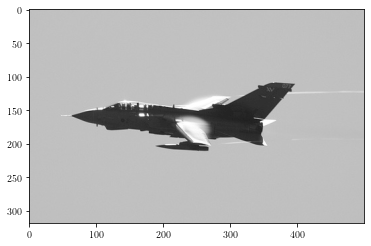

In [983]:
# img_o = Image.open("dataset_bp/#BP029_10.jpg").convert("L")
img_o = Image.open("database_pascal/2007_004052.jpg").convert("L")

dim = (img_o.size[1], img_o.size[0])
# print(dim)
# if dim[0]>100:
#     basewidth = 100
#     wpercent = (basewidth/float(img_o.size[0]))
#     hsize = int((float(img_o.size[1])*float(wpercent)))
#     img_o = img_o.resize((basewidth,hsize), Image.ANTIALIAS)

# dim = (img_o.size[1], img_o.size[0])
# print(dim)  

img = np.array(img_o.getdata()).reshape((dim[0], dim[1]))


plt.imshow(img, cmap="gray")

<set_image> img: <class 'numpy.ndarray'>, reshape: True, norm: True
|img_dim:     [319 500]
|img_min/max: (25, 255)
|new_img_min/max(resize): (2.6100973857345178e-08, 1.1778249636024502e-07)
|new_dim:     [ 63 100]
|new_img_min/max(norm): (0, 254)
|size_domain: 6300
</set_image>
Wall time: 31.9 ms


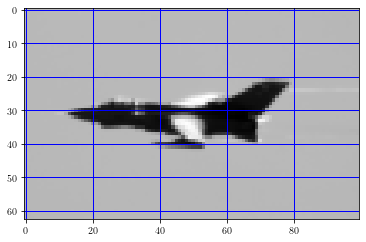

In [984]:
%%time
segmentator = LevelSetMethod()
segmentator.set_image(
    img, 
    reshape=True,
    norm=True
)
segmentator.show_image(grid=True)

Wall time: 310 ms


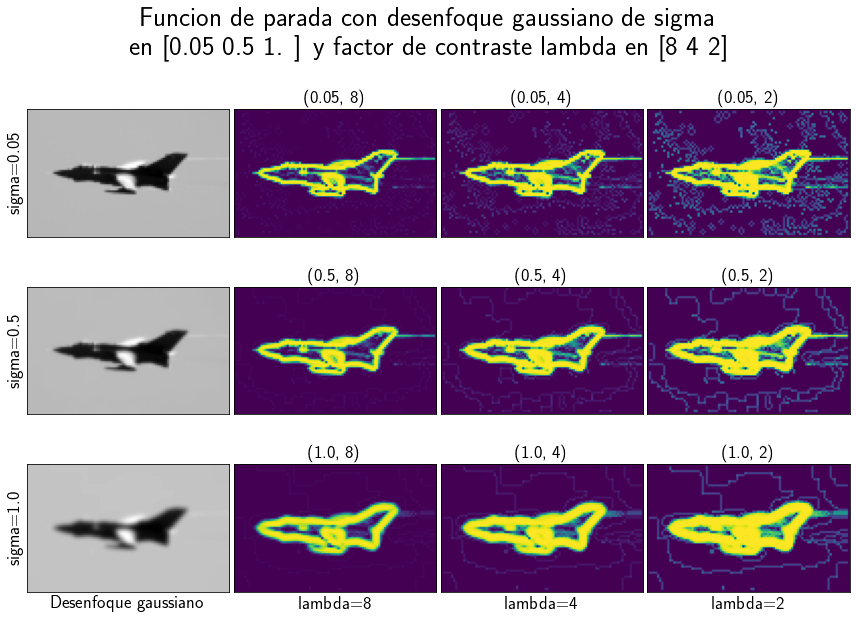

In [985]:
%%time
segmentator.eval_stopfunct(
    list_sgm=np.array([0.05, 0.5, 1]), 
    list_lmbd=np.array([8, 4, 2]),
    cmap="viridis_r"
)

In [986]:
%%time
segmentator.set_stopfunct(
    sgm=0.05, 
    lmbd=8,
)

<set_stopfunct> sigma: 0.05, lambda: 8
|gauss_min/max: (0, 254)
|stopfunct_min/max:     (0.0018376019294820264, 1.0)
</set_stopfunct>
Wall time: 2.96 ms


Wall time: 45.8 ms


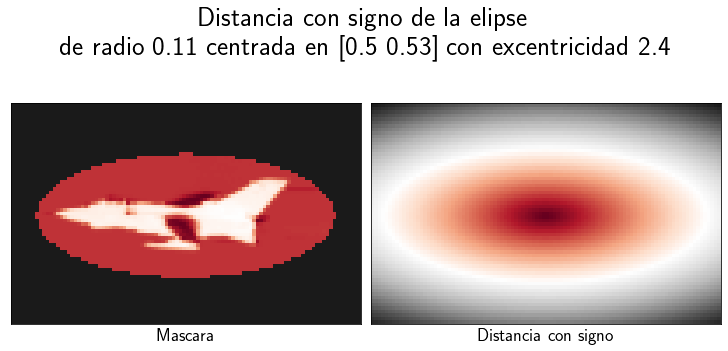

In [987]:
%%time
segmentator.eval_sgndist(
    c=np.array([0.5, 0.51]), 
    r=0.11,
    e=2.4
)

In [988]:
%%time
segmentator.set_sgndist(
    c=np.array([0.5, 0.51]), 
    r=0.11,
    e=2.4
)

<set_sgndist> centro: [0.5  0.51], radio: 0.11, excentricidad: 2.4
</set_sgndist>
Wall time: 2.96 ms


Wall time: 90.8 ms


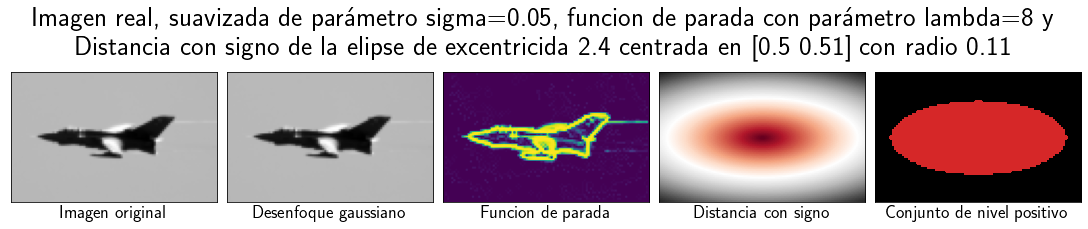

In [989]:
%%time 
segmentator.show_setting(cmap_stopfunct="viridis_r")

In [873]:
# %%time
# tau = 0.25
# kappa=-2
# sgm=0.3
# lmbd=5
# a, img_blurred = stopping_func(img, dim, domain, sgm=sgm, lmbd=lmbd)
# b = np.ones( dim[0] * dim[1] )

# x0 = np.array([0.5, 0.5])
# r = 0.18
# e=0.9

# u0 = signed_function(r, x0, dim, e)
# # u0[u0>0] = np.sign(u0[u0>0]) * (u0[u0>0]**2)/8

# A0_star, B0_star, norm_grad = A_B(u0, a, b, domain, dim, tau, kappa)
# plt.imshow(B0_star.reshape((dim[0], dim[1])))

In [369]:
un = u0
iterations = [u0]
times = [0]

<ipython-input-38-08b6e7850594>:60: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-38-08b6e7850594>:62: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-38-08b6e7850594>:64: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-38-08b6e7850594>:66: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


n: 0 time: 3.51216721534729
n: 1 time: 3.46248722076416
n: 2 time: 3.865448474884033
n: 3 time: 3.770754337310791
n: 4 time: 3.7823057174682617
n: 5 time: 3.572904109954834
n: 6 time: 3.711716651916504
n: 7 time: 3.430385112762451
n: 8 time: 3.8394696712493896
n: 9 time: 3.78112530708313
n: 10 time: 4.267489910125732
n: 11 time: 3.642038345336914
n: 12 time: 3.779094696044922
n: 13 time: 3.7939727306365967
n: 14 time: 3.8499865531921387
n: 15 time: 3.5690908432006836
n: 16 time: 3.691006660461426
n: 17 time: 4.270918369293213
n: 18 time: 3.917318344116211
n: 19 time: 3.623772382736206


<timed exec>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


n: 20 time: 3.7849042415618896
n: 21 time: 3.7848544120788574
n: 22 time: 3.5704424381256104
n: 23 time: 3.843599319458008
n: 24 time: 3.580249309539795
n: 25 time: 4.048774242401123
n: 26 time: 3.767885684967041
n: 27 time: 3.8130226135253906
n: 28 time: 3.9405384063720703
n: 29 time: 3.8359456062316895
n: 30 time: 3.829185962677002
n: 31 time: 3.9274532794952393
n: 32 time: 4.011149168014526
n: 33 time: 3.7579197883605957
n: 34 time: 3.81620454788208
n: 35 time: 3.7988102436065674
n: 36 time: 3.8831589221954346
n: 37 time: 3.71492862701416
n: 38 time: 3.8621695041656494
n: 39 time: 3.8502402305603027
n: 40 time: 3.888650417327881
n: 41 time: 3.8591442108154297
n: 42 time: 3.9019548892974854
n: 43 time: 4.0148024559021
n: 44 time: 3.771784543991089
n: 45 time: 4.067544937133789
n: 46 time: 3.8418285846710205
n: 47 time: 4.110603332519531
n: 48 time: 3.9129130840301514
n: 49 time: 3.904358148574829
n: 50 time: 3.88920259475708
n: 51 time: 3.7669146060943604
n: 52 time: 3.78554296493530

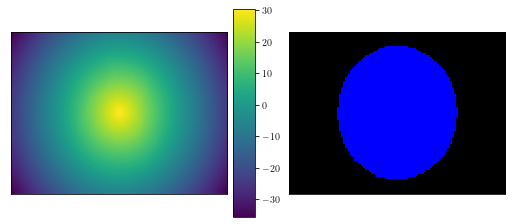

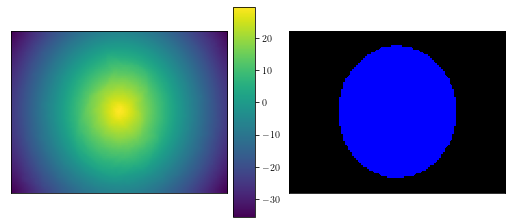

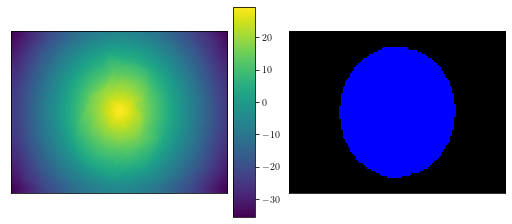

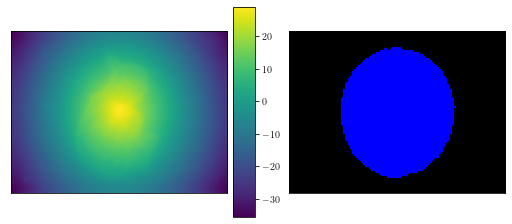

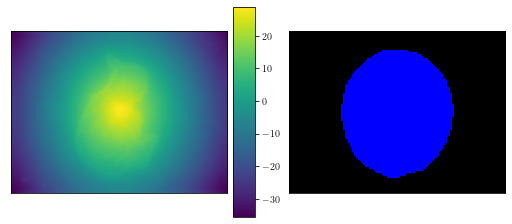

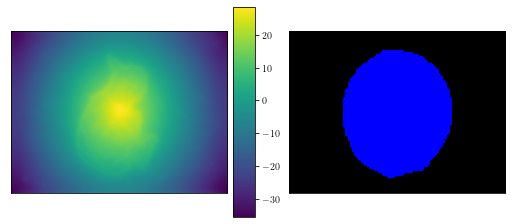

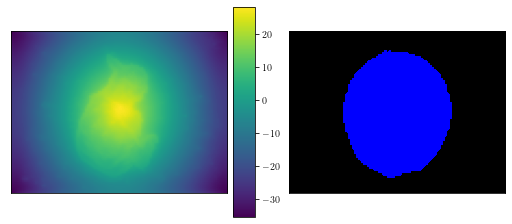

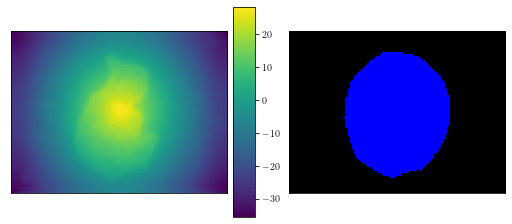

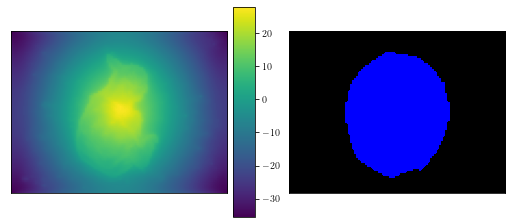

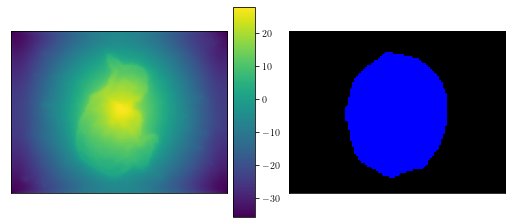

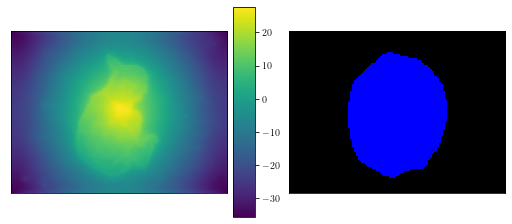

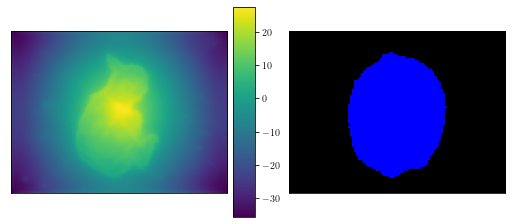

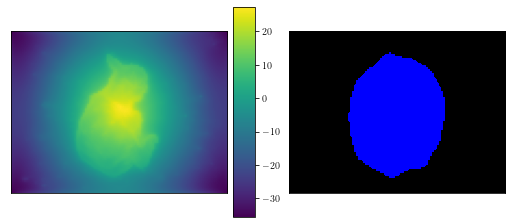

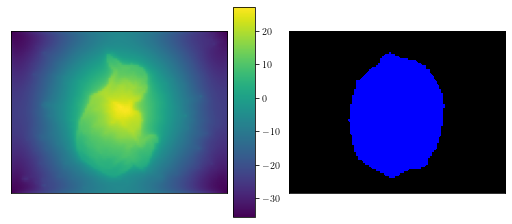

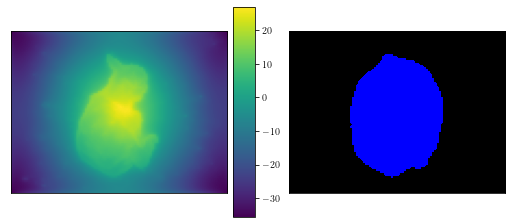

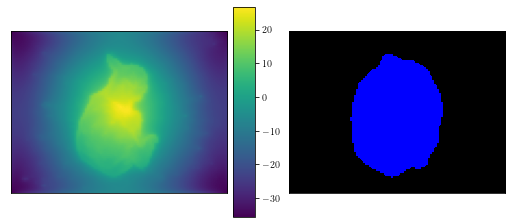

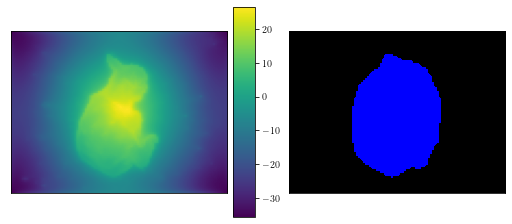

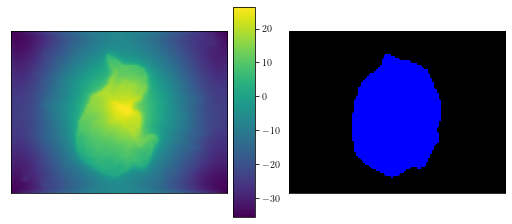

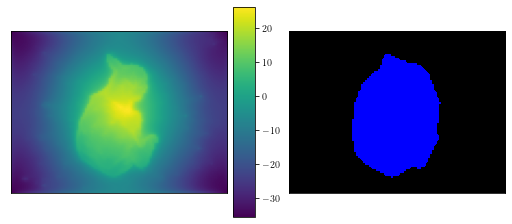

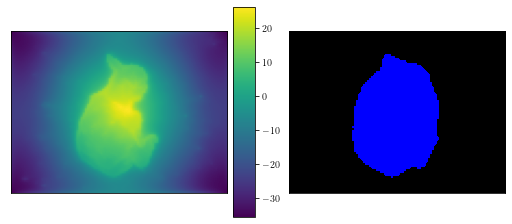

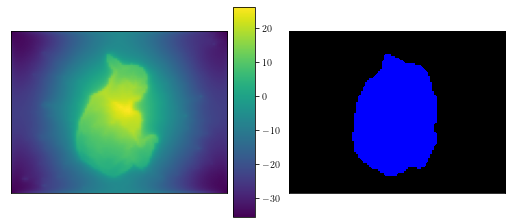

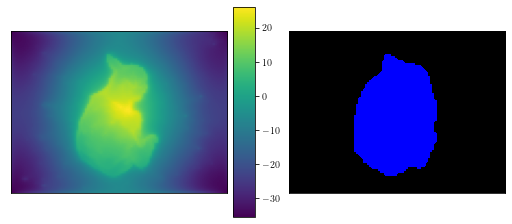

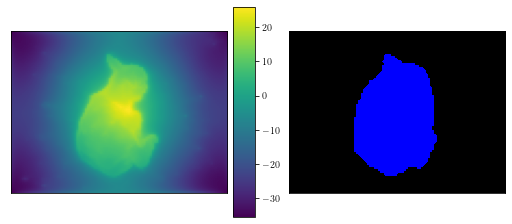

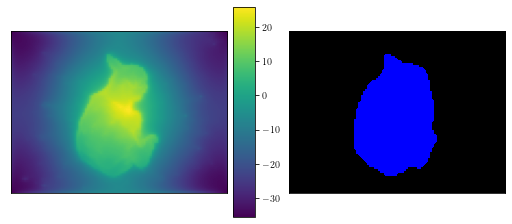

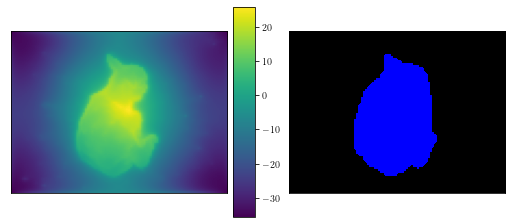

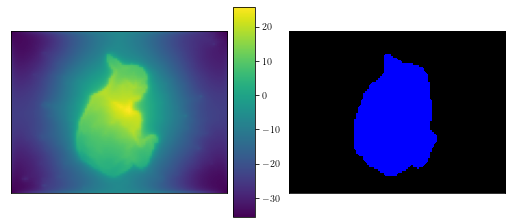

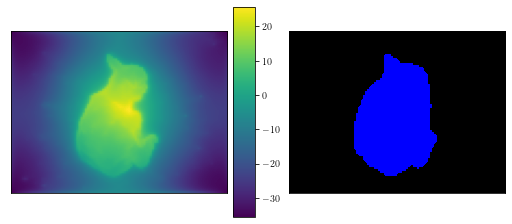

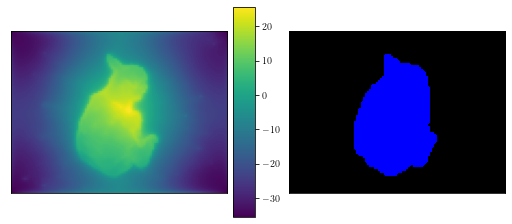

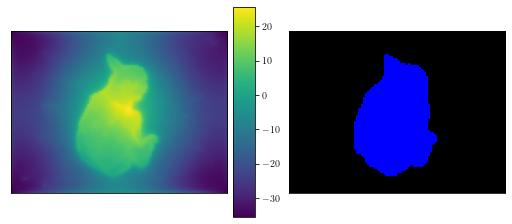

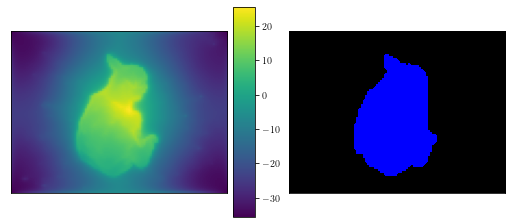

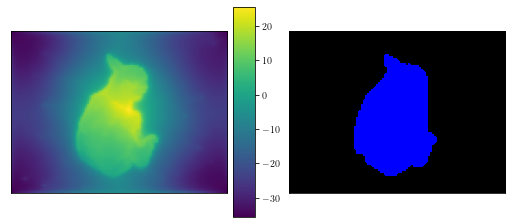

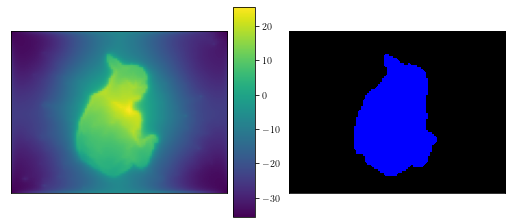

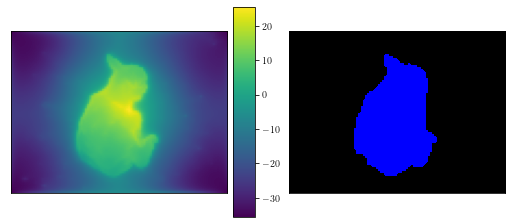

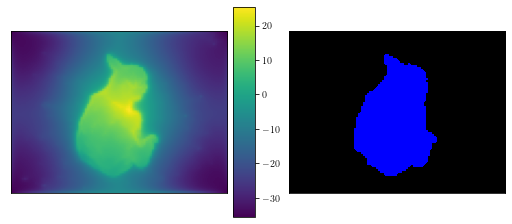

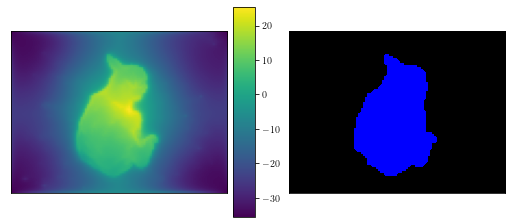

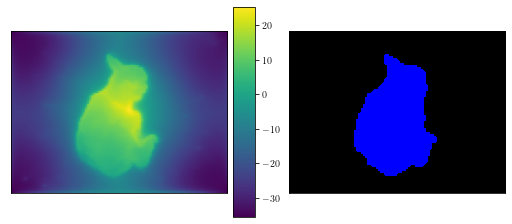

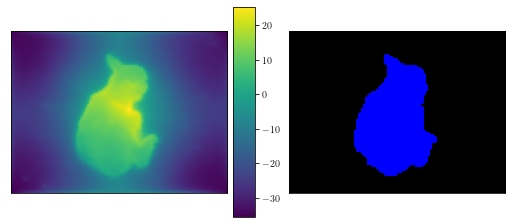

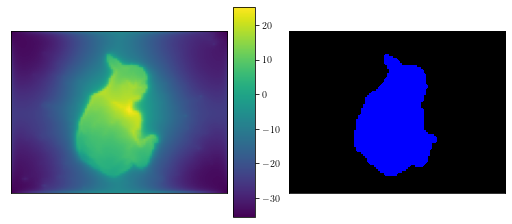

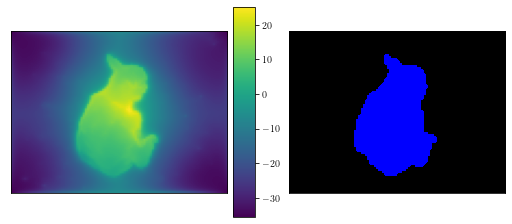

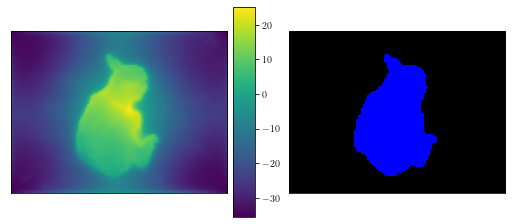

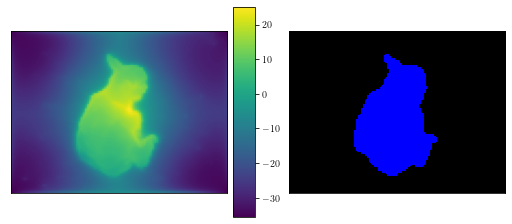

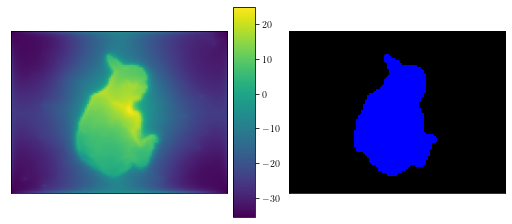

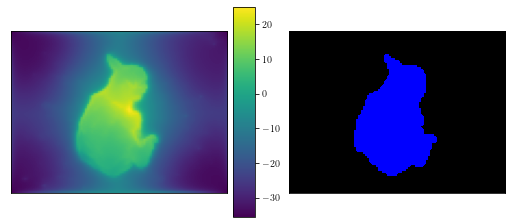

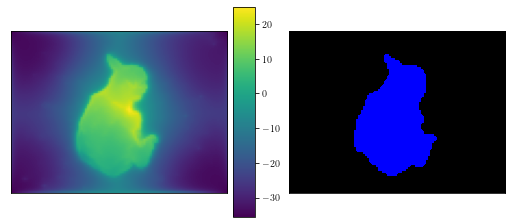

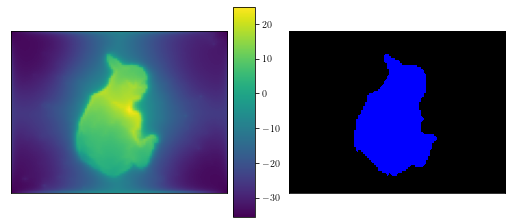

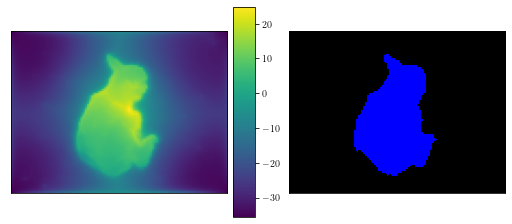

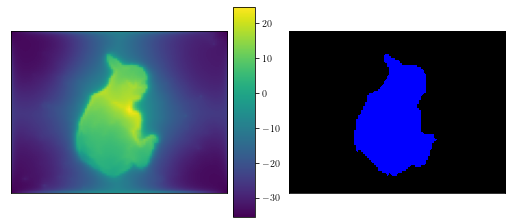

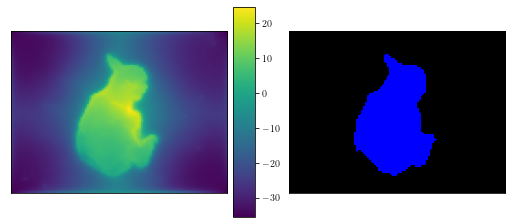

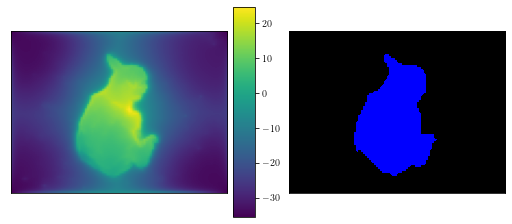

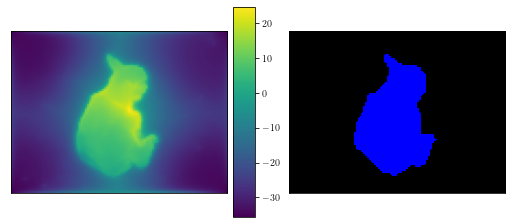

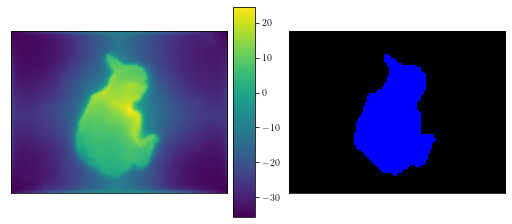

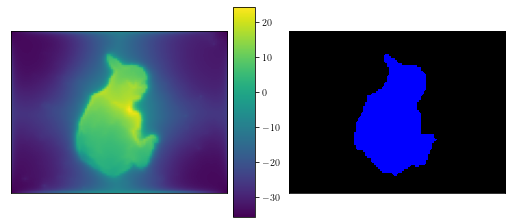

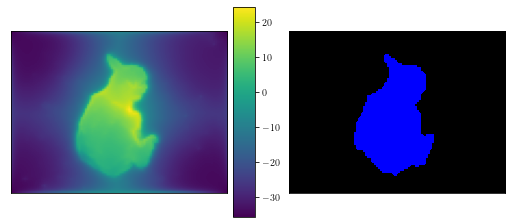

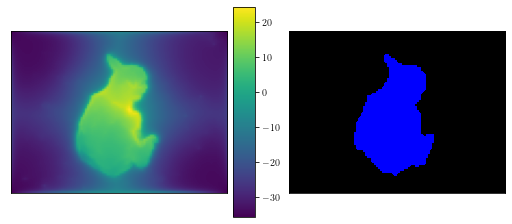

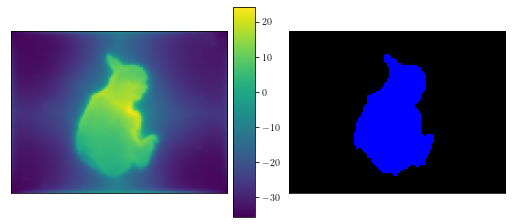

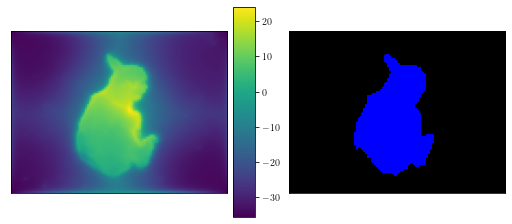

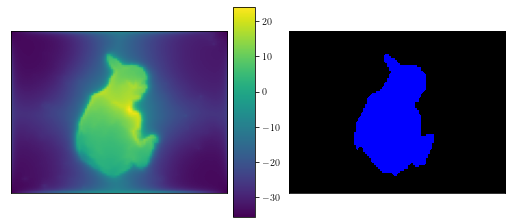

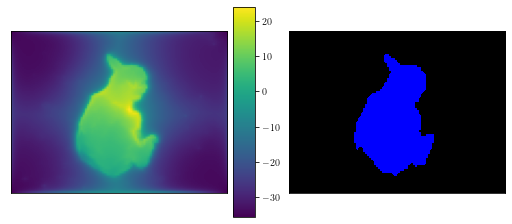

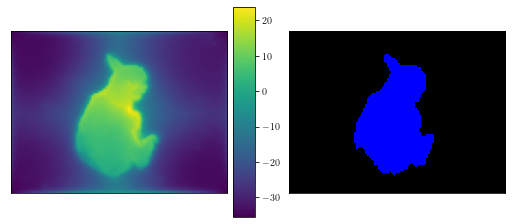

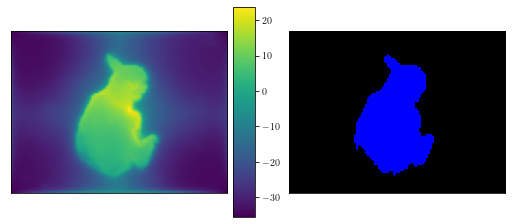

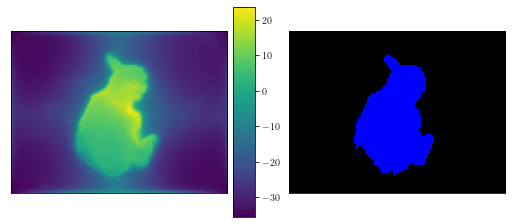

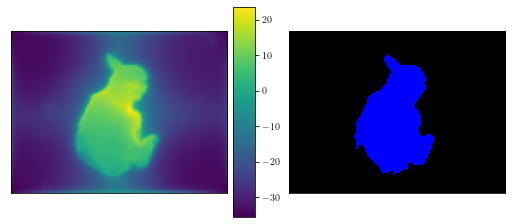

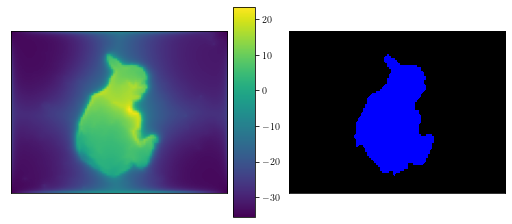

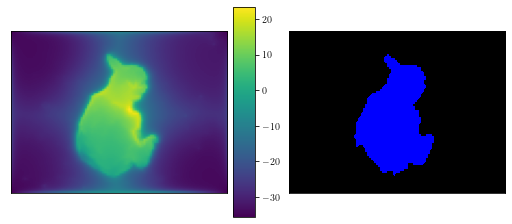

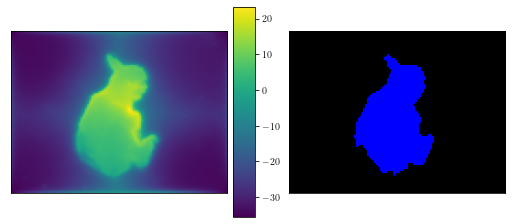

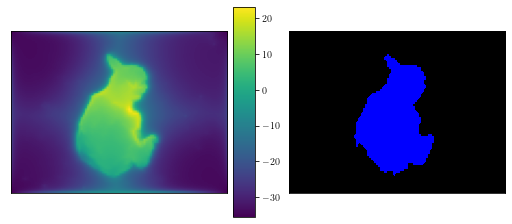

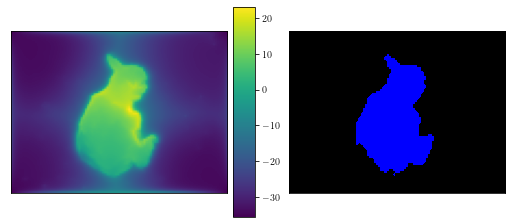

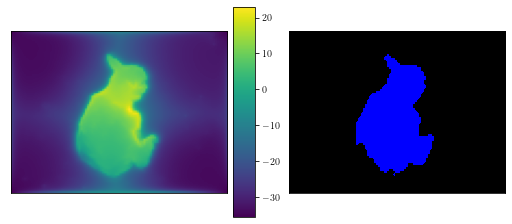

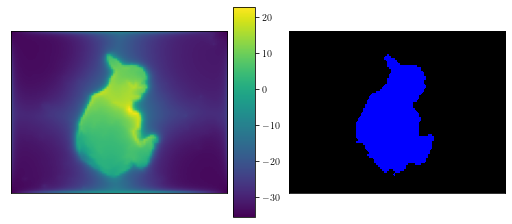

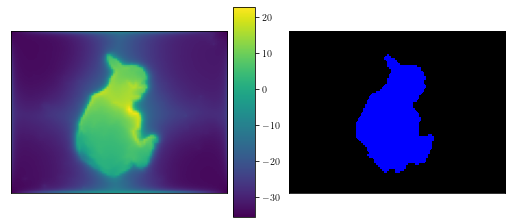

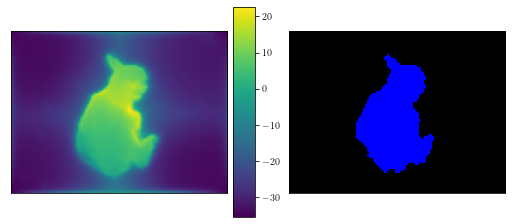

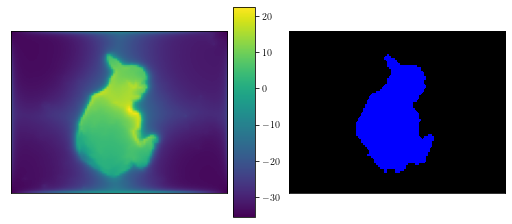

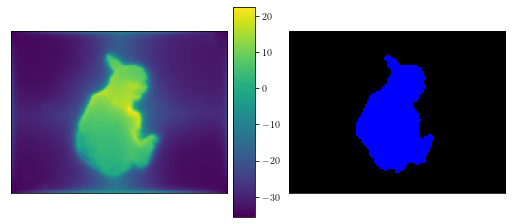

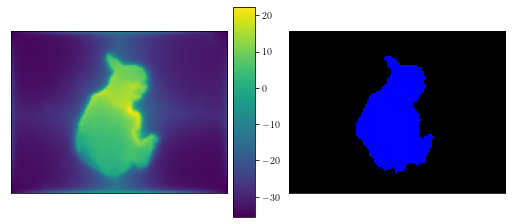

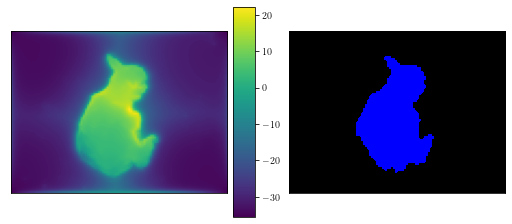

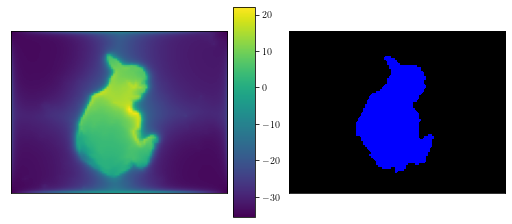

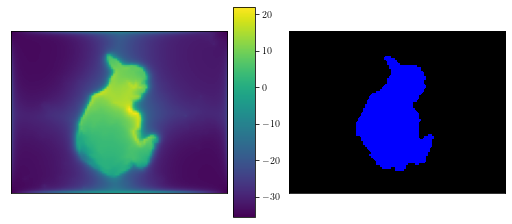

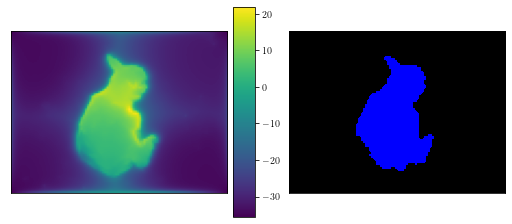

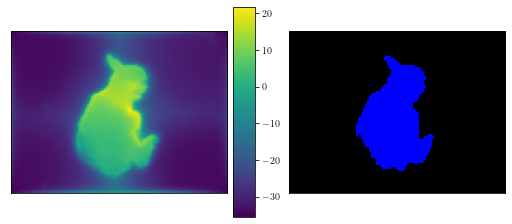

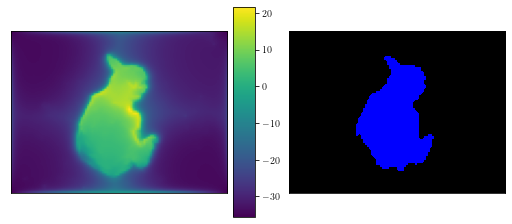

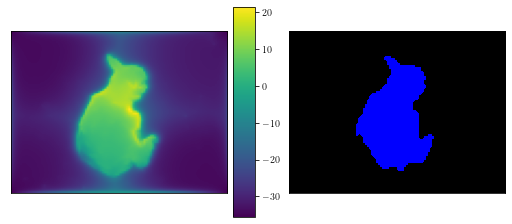

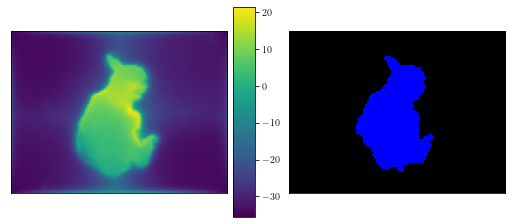

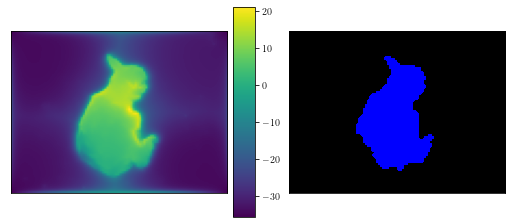

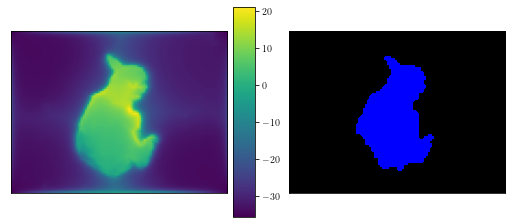

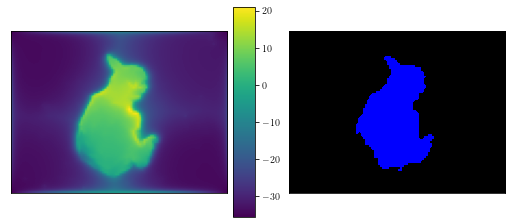

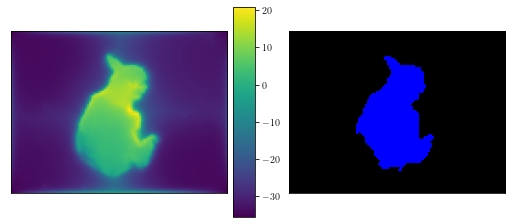

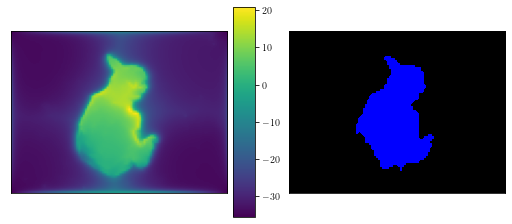

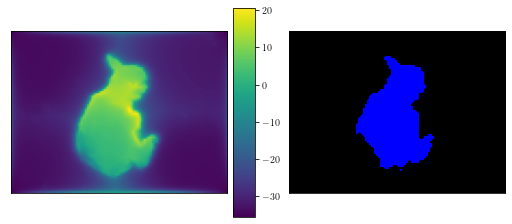

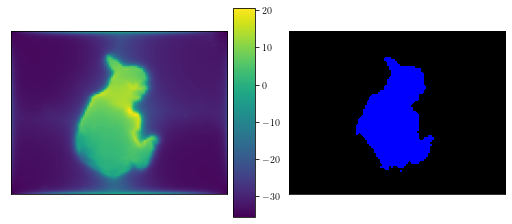

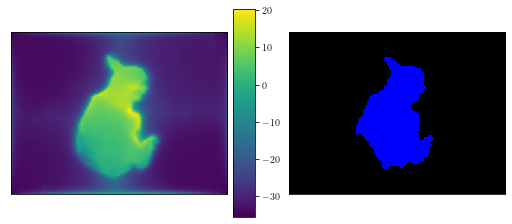

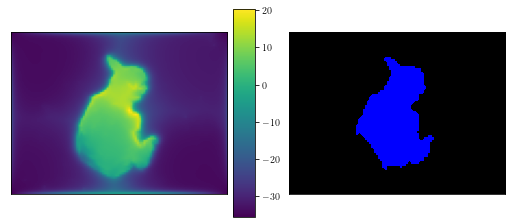

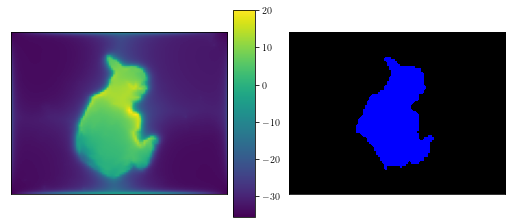

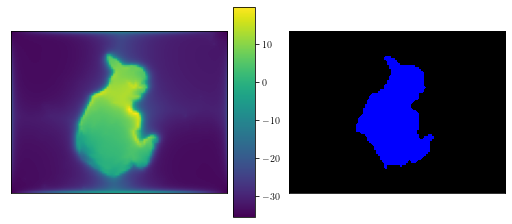

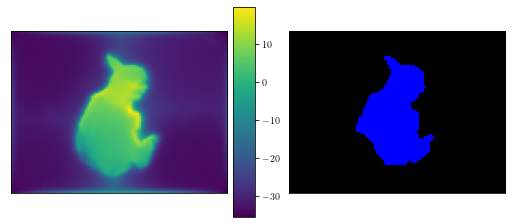

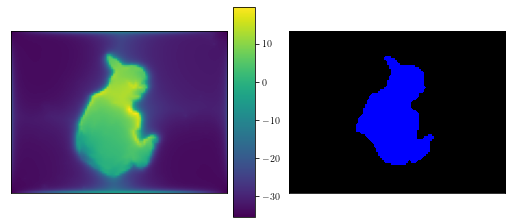

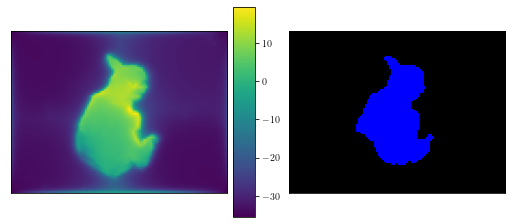

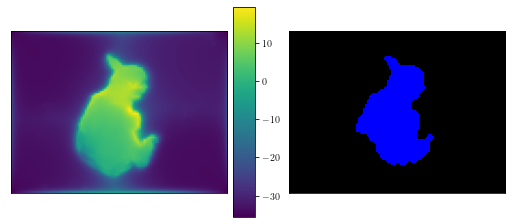

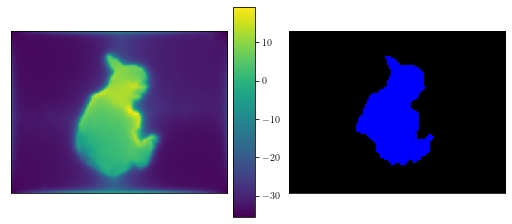

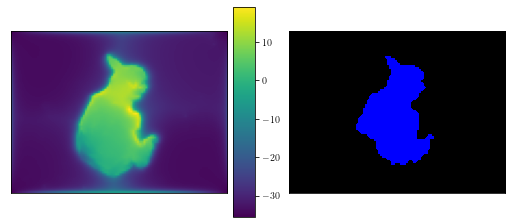

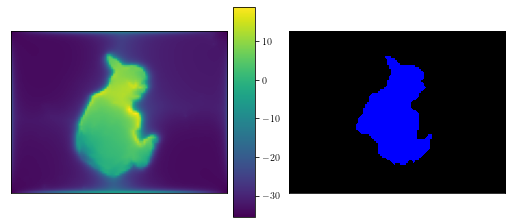

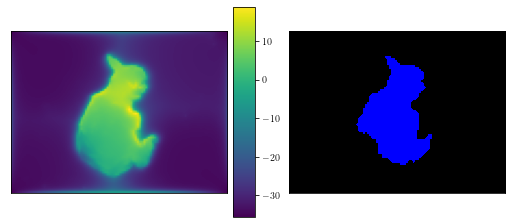

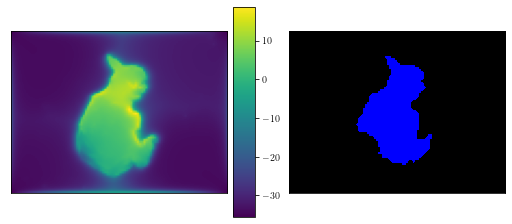

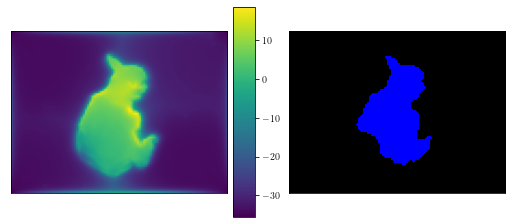

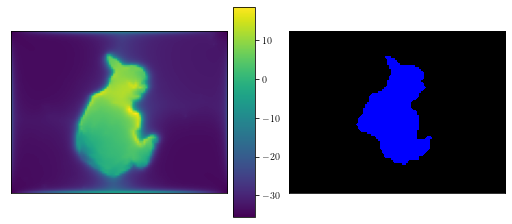

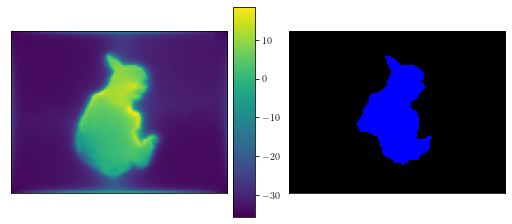

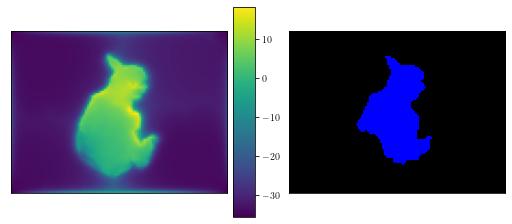

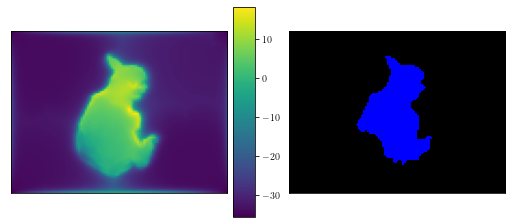

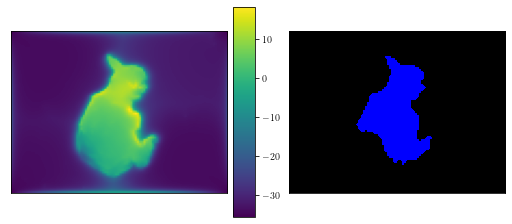

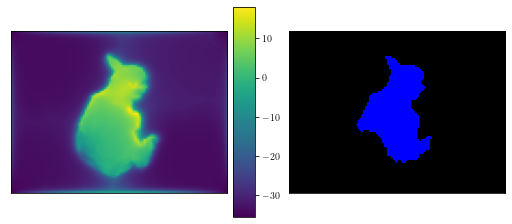

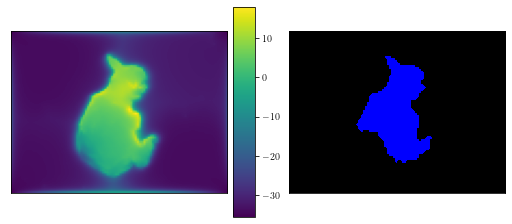

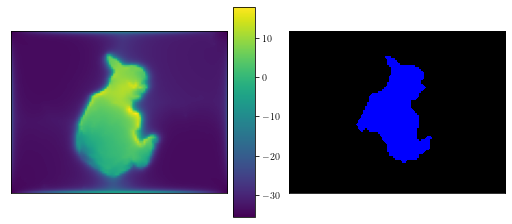

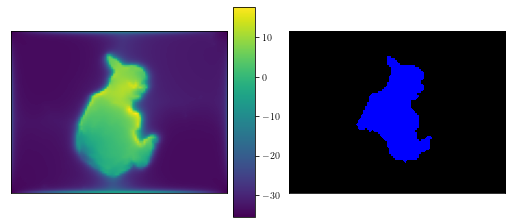

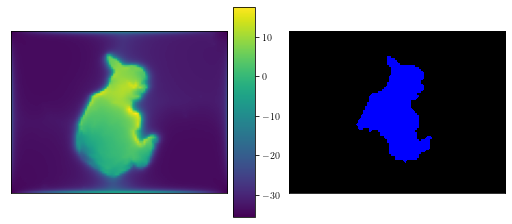

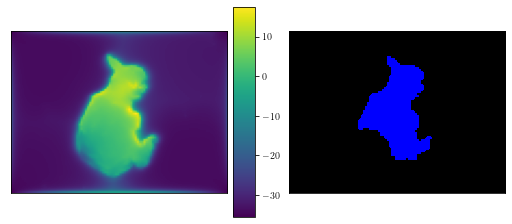

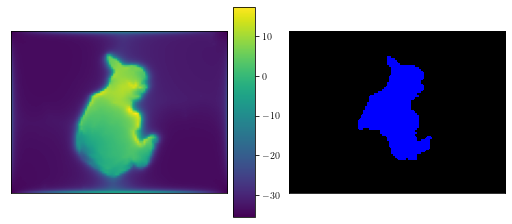

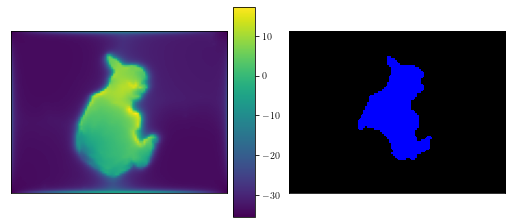

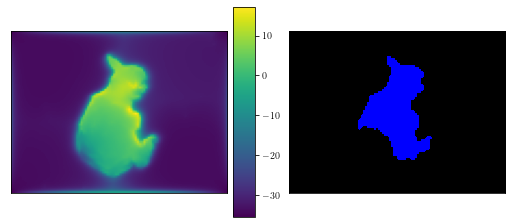

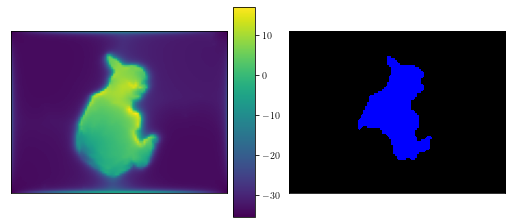

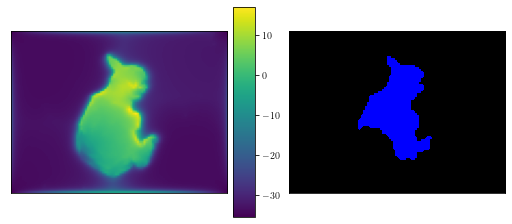

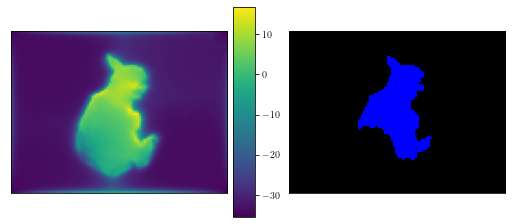

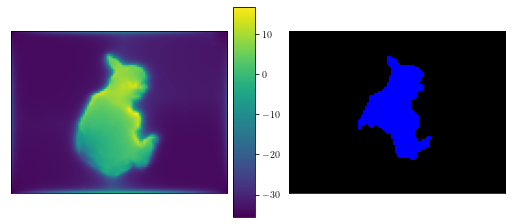

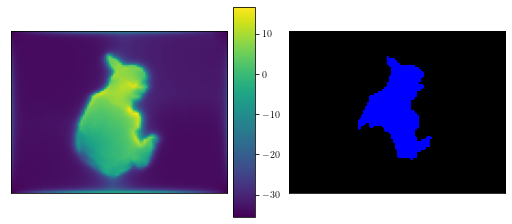

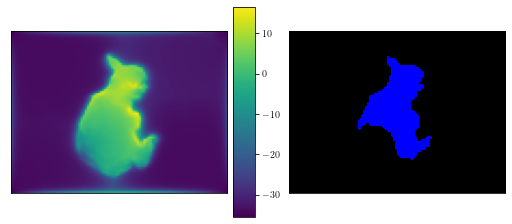

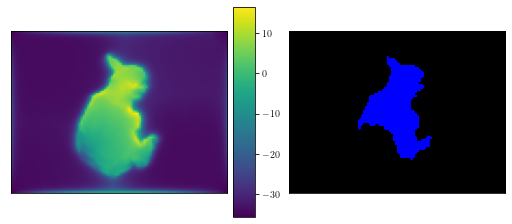

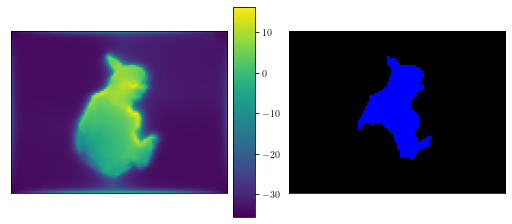

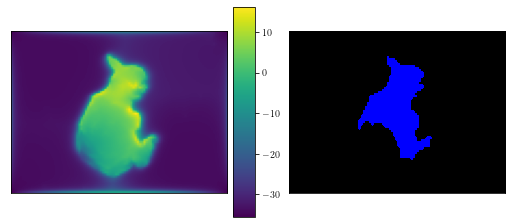

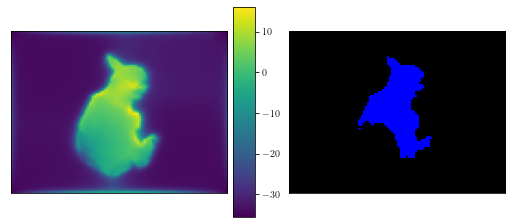

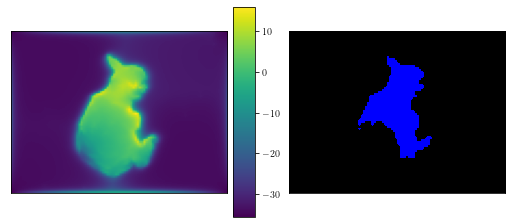

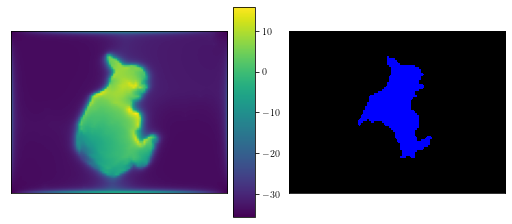

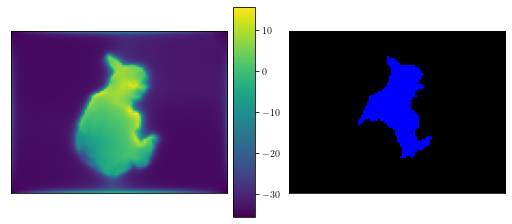

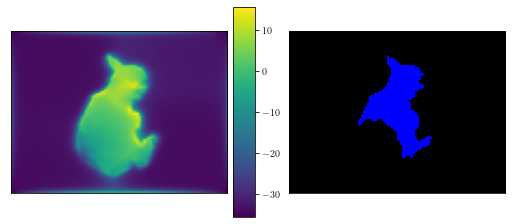

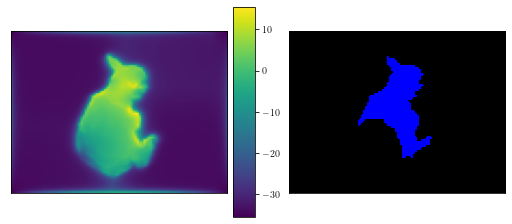

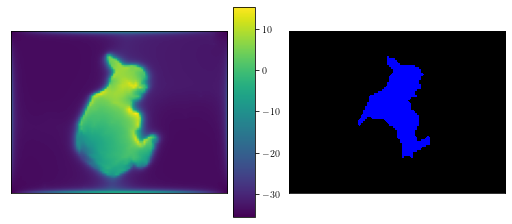

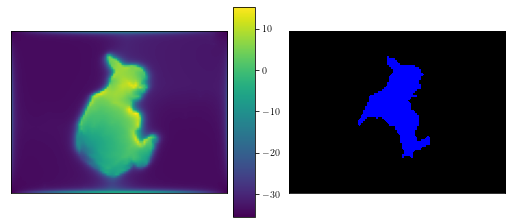

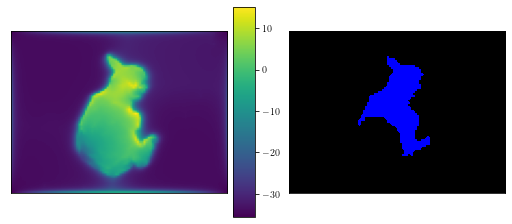

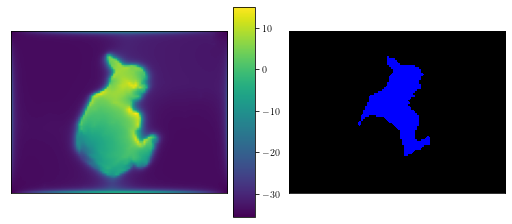

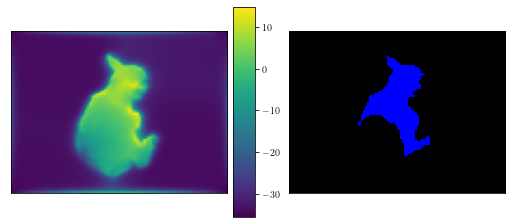

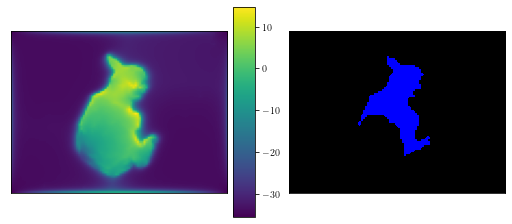

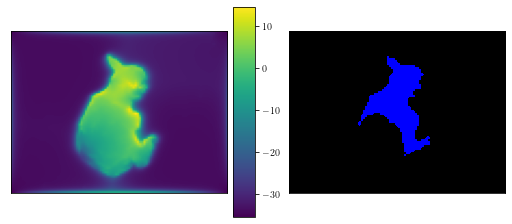

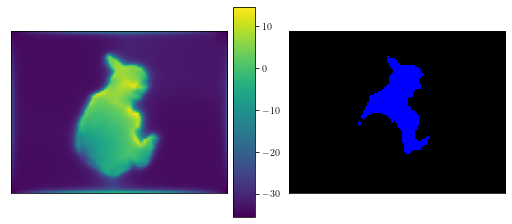

In [371]:
%%time
for n in range(140):
    start = time.time()
    An_star, Bn_star, _ = A_B(un, a, b, domain, dim, tau, kappa)
    un1 = spsolve(An_star, Bn_star)
    cvn = un1>0

    fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
    im = ax[0].imshow(un1.reshape(dim[0], dim[1]))
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    fig.colorbar(im, cax=ax[1], orientation='vertical')

    ax[2].imshow(cvn.reshape(dim[0], dim[1]), cmap=ListedColormap(['black','blue']))
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);

    plt.savefig(f"image_test21/un_{n}.png", bbox_inches='tight');

    un = un1
    iterations.append(un)
    end = time.time()
    
    times.append(end-start)
    print("n:", n, "time:", times[-1])

In [12]:
pickle.dump(iterations, open("iterations0.pickle", "wb"))
pickle.dump(times, open("times0.pickle", "wb"))

mean: 4.063919852461134 std: 1.1708166524092212


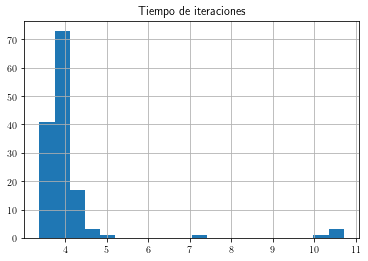

In [373]:
rel_times = times[1:]
pd.DataFrame(rel_times, columns=["Tiempo de iteraciones"]).hist(bins=20);
print("mean:", np.mean(rel_times), "std:", np.std(rel_times))

Text(0.5, 0.98, 'Resultados para la iteraciones 1, 23 y 49')

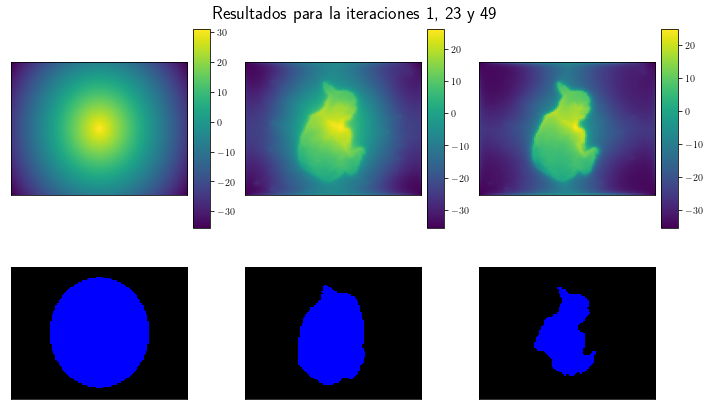

In [374]:
fig, ax = plt.subplots(2, 6, figsize=(3*3+3*0.25, 3*2), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1]})

# Funciones
im = ax[0, 0].imshow(iterations[0].reshape(dim[0], dim[1]))
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

fig.colorbar(im, cax=ax[0, 1], orientation='vertical')

im = ax[0, 2].imshow(iterations[23].reshape(dim[0], dim[1]))
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fig.colorbar(im, cax=ax[0, 3], orientation='vertical')

im = ax[0, 4].imshow(iterations[49].reshape(dim[0], dim[1]))
ax[0, 4].set_xticks([])
ax[0, 4].set_yticks([])

fig.colorbar(im, cax=ax[0, 5], orientation='vertical')

# Curvas
im = ax[1, 0].imshow((iterations[0]>0).reshape(dim[0], dim[1]), cmap=ListedColormap(['black','blue']))
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

im = ax[1, 2].imshow((iterations[23]>0).reshape(dim[0], dim[1]), cmap=ListedColormap(['black','blue']))
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

im = ax[1, 4].imshow((iterations[100]>0).reshape(dim[0], dim[1]), cmap=ListedColormap(['black','blue']))
ax[1, 4].set_xticks([])
ax[1, 4].set_yticks([])

for axc in [ax[1, 1], ax[1, 3], ax[1, 5]]:
    axc.remove()

plt.suptitle("Resultados para la iteraciones 1, 23 y 49", size=18)
# plt.savefig("res_exp5.png", bbox_inches='tight');

(375, 500)
(75, 100)


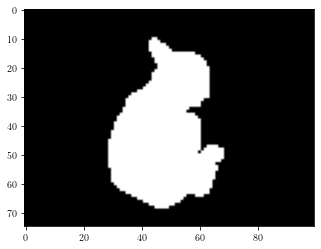

In [375]:
img_r = Image.open("database_pascal/2008_004621.png").convert("L")

dim_r = (img_r.size[1], img_r.size[0])
print(dim_r)
if dim_r[0]>100:
    basewidth = 100
    wpercent = (basewidth/float(img_r.size[0]))
    hsize = int((float(img_r.size[1])*float(wpercent)))
    img_r = img_r.resize((basewidth,hsize), Image.ANTIALIAS)

dim_r = (img_r.size[1], img_r.size[0])
print(dim_r)  

img_r = np.array(img_r.getdata()).reshape((dim_r[0], dim_r[1])).flatten()
img_r = (img_r>6).astype(int)
plt.imshow(img_r.reshape(dim_r[0], dim_r[1]), cmap="gray")

In [376]:
clf = [(un>0).astype(int) for un in iterations]

In [290]:
from sklearn.metrics import roc_curve

In [377]:
ROC = [roc_curve(img_r, clf_k, pos_label=1) for clf_k in clf]

In [386]:
FPR = np.array([roc_k[0][1] for roc_k in ROC])
TPR = np.array([roc_k[1][1] for roc_k in ROC])

In [399]:
np.argmin((TPR-1)**2+FPR**2)

20

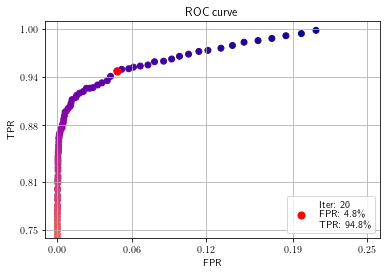

In [427]:
plt.scatter(FPR, TPR, c=range(len(ROC)), cmap="plasma")
plt.scatter([FPR[20]], [TPR[20]], c="red", s=50, label=f"Iter: {20}\nFPR: {100*FPR[20]: .1f}\%\nTPR: {100*TPR[20]: .1f}\%")
plt.yticks(np.linspace(3/4, 1, 5).round(2));
plt.xticks(np.linspace(0, 1/4, 5).round(2));
plt_eps = 0.01
plt.xlim([0-plt_eps, 1/4+plt_eps])
plt.ylim([3/4-plt_eps, 1+plt_eps])
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.grid()
plt.legend(fontsize=10, loc=4)
plt.title("ROC curve");